## <font color=steelblue>Ejercicio 1 - Interpolación de datos faltantes

<font color=steelblue>La figura muestra una cuenca hidrográfica experimental y la ubicación de 11 pluviómetros en su zona de influencia. La estación F dejó de funcionar durante una tormenta, con lo que no se dispone de datos en ella. Utiliza los datos que sí registraron el resto de estaciones de la cuenca para estimar la precipitación en F.

<img src="img/RainGages.png" alt="Mountain View" style="width:300px">
    
<font color=steelblue>Los datos de precipitación se encuentran en el archivo *RainfallData_Exercise_001.csv*.

| Gage | X      | Y       | Average Annual Precip. (mm) | Measured Storm Precip. (mm) |
|------|--------|---------|-----------------------------|-----------------------------|
| C    | 385014 | 4778553 | 1404                        | 11.6                        |
| D    | 389634 | 4779045 | 1433                        | 14.8                        |
| E    | 380729 | 4775518 | 1665                        | 13.3                        |
| F    | 387259 | 4776670 | 1137                        | -                           |
| G    | 389380 | 4776484 | 1235                        | 12.3                        |
| H    | 382945 | 4772356 | 1114                        | 11.5                        |
| I    | 386399 | 4771795 | 1101                        | 11.6                        |
| J    | 388397 | 4772419 | 1086                        | 11.2                        |
| K    | 389287 | 4771097 | 1010                        | 9.7                         |
    

#### Métodos:
[1.1 Método de la media](#Método-de-la-media)<br>
[1.2 Método de la razón normal](#Método-de-la-razón-normal)<br>
[1.3 Método de la distancia inversa](#Método-de-la-distancia-inversa)<br>

Los métodos de completado de datos siguen, al igual que muchos métodos de interpolación, la siguiente fórmula general:

$$\hat{p_o} = \sum_{i=1}^{n} w_i·p_i$$

Donde $\hat{p_o}$ es el dato de precipitación en la estación que queremos interpolar, $n$ es el número de estaciones, $w_i$ y $p_i$ son la ponderación y la precipitación recogida en cada una de las estaciones a partir de las cuales se completa/interpola.

In [3]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
#plt.style.use('seaborn-whitegrid')

from scipy.stats import genextreme
from scipy.optimize import curve_fit

Se importan los datos a través de _pandas_ y se guardan en un objeto (_data frame_ en terminología _pandas_).

In [4]:
# Importar 'RainfallData_Exercise_001.csv'
data1 = pd.read_csv('..\data\RainfallData_Exercise_001.csv', index_col=0)
data1

,X,Y,Average Annual Precip. (mm),Measured Storm Precip. (mm)
Gage,,,,
A,387706,4781780,1373,14.4
B,383422,4778885,1452,12.2
C,385014,4778553,1404,11.6
D,389634,4779045,1433,14.8
E,380729,4775518,1665,13.3
F,387259,4776670,1137,NaN
G,389380,4776484,1235,12.3
H,382945,4772356,1114,11.5
I,386399,4771795,1101,11.6


Un _data frame_ tiene asociados una serie de atributos. Por ejemplo, se puede extraer la dimensión de la tabla (`shape`), el número total de elemenos (`size`), el nombre de las variables (`columns`) o los datos en forma de _numpy array_ (`values`).

In [5]:
#dimensión
data1.shape

(11, 4)

In [6]:
# nº de datos
data1.size

44

In [7]:
# índice
data1.index

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'], dtype='object', name='Gage')

In [8]:
# columnas
data1.columns

Index(['X', 'Y', 'Average Annual Precip. (mm)', 'Measured Storm Precip. (mm)'], dtype='object')

Además, se pueden aplicar sobre él funciones de cualquier tipo. Por ejemplo, la función `describe` genera un resumen estadístico de cada una de las variables (columnas) del _data frame_.

In [9]:
# resumen
data1.describe()

,X,Y,Average Annual Precip. (mm),Measured Storm Precip. (mm)
count,11.000000,1.100000e+01,11.000000,10.000000
mean,386379.272727,4.775873e+06,1273.636364,12.260000
std,2983.076804,3.550817e+03,204.304808,1.536374
min,380729.000000,4.771097e+06,1010.000000,9.700000
25%,384218.000000,4.772388e+06,1107.500000,11.525000
50%,387259.000000,4.776484e+06,1235.000000,11.900000
75%,388842.000000,4.778719e+06,1418.500000,13.050000
max,389634.000000,4.781780e+06,1665.000000,14.800000


In [10]:
# media
round(data1.mean(), 0)

X                               386379.0
Y                              4775873.0
Average Annual Precip. (mm)       1274.0
Measured Storm Precip. (mm)         12.0
dtype: float64

In [11]:
# primeras líneas
data1.head()

,X,Y,Average Annual Precip. (mm),Measured Storm Precip. (mm)
Gage,,,,
A,387706,4781780,1373,14.4
B,383422,4778885,1452,12.2
C,385014,4778553,1404,11.6
D,389634,4779045,1433,14.8
E,380729,4775518,1665,13.3


Para seleccionar un dato o un conjunto de datos de un _data frame_ debe indicarse la fila y columna bien a través de su nombre o de su posición. 

* La función `.loc` permite extraer datos a través del nombre de las filas y columnas.

* La función `.iloc` permite extraer datos a través de la posición de las filas y columnas. IMPORTANTE: la posición en Python se inicia desde el 0, es decir, la primera fila es la fila 0, no la 1.

In [12]:
# Extraer mediante .loc
data1.loc['A', 'Measured Storm Precip. (mm)']
data1.loc['A', :]
data1.loc[['A', 'C'], 'Average Annual Precip. (mm)']

Gage
A    1373
C    1404
Name: Average Annual Precip. (mm), dtype: int64

In [13]:
# extraer mediante .iloc
data1.iloc[0, 0]
data1.iloc[0, :]
data1.iloc[[0, 2], 1]

Gage
A    4781780
C    4778553
Name: Y, dtype: int64

In [14]:
# extraer una columna por nombre
data1['Average Annual Precip. (mm)']

Gage
A    1373
B    1452
C    1404
D    1433
E    1665
F    1137
G    1235
H    1114
I    1101
J    1086
K    1010
Name: Average Annual Precip. (mm), dtype: int64

In [15]:
# Simplificar el nombre de las columnas
# d: distancia a F en km
# P: precipitación media anual en mm
# p: precipitación en la tormenta de interés en mm
data1.columns = ['X', 'Y', 'Pan', 'p']

data1.head(2)

,X,Y,Pan,p
Gage,,,,
A,387706,4781780,1373,14.4
B,383422,4778885,1452,12.2


### Método de la media

En el método de la media se asimila la precipitación en el punto de estudio como la media de la precipitación en las estaciones en su alrededor.

Siguiendo la ecuación del inicio, se da el mismo  peso a todas las estaciones ($\frac{1}{n}$), siendo *n* el número de estaciones consideradas.

$$w_i=\frac{1}{n}$$

$$\hat{p_o} = \frac{1}{n}\sum_{i=1}^{n} p_i$$

In [16]:
po_mm = data1['p'].mean()

In [17]:
print('La precipitación en F es:')
print('pf =', round(po_mm, 1), 'mm')

La precipitación en F es:
pf = 12.3 mm


Al hacer la media de todas las estaciones de las que disponemos de datos obtenemos un valor suavizado de la precipitación en F. Es decir, puede ser que estemos teniendo en cuenta datos de estaciones lo suficientemente lejanas como para que su dato de precipitación no sea representativo de la precipitación en F.

Para evitar en este problema, se suele aplicar el método de la media utilizando únicamente la estación más cercana del punto de interés en cada uno de los cuatro cuadrantes.

In [18]:
closest = ['C', 'D', 'G', 'I']
po_mmc = data1.loc[closest, 'p'].mean()

print('La precipitación en F es:')
print('pf =', round(po_mmc, 1), 'mm')

La precipitación en F es:
pf = 12.6 mm


### Método de la razón normal

Otra forma de tener en cuenta la conexión entre la precipitación en una estación cualquiera y la precipitación objetivo es incluir el cociente entre la precipitación anual media en ambas estaciones, es decir, la razón normal.

Aplicando esta correción sobre el método de la media se obtiene el método de la razón normal.

$$w_i = \frac{1}{n}\frac{P_o}{P_i} = \frac{1}{n}RN$$

$$\hat{p_o} = \frac{1}{n}\sum_{i=1}^{n} \frac{P_o}{P_i} p_i$$

Donde $P_o$ y $P_i$ son la precipitación media anual en la estación objetivo y las estaciones utilizadas en la interpolación, repectivamete, y $NR$ es la razón normal.

In [19]:
# Extraer las estaciones con registro
data1_ = data1.drop('F').copy()
data1_

,X,Y,Pan,p
Gage,,,,
A,387706,4781780,1373,14.4
B,383422,4778885,1452,12.2
C,385014,4778553,1404,11.6
D,389634,4779045,1433,14.8
E,380729,4775518,1665,13.3
G,389380,4776484,1235,12.3
H,382945,4772356,1114,11.5
I,386399,4771795,1101,11.6
J,388397,4772419,1086,11.2


In [20]:
# Calcular el cociente entre la precipitación anual en 'F' y en cada una de las otras estaciones
data1_['RN'] = data1.loc['F', 'Pan'] / data1_['Pan']

data1_

,X,Y,Pan,p,RN
Gage,,,,,
A,387706,4781780,1373,14.4,0.828114
B,383422,4778885,1452,12.2,0.783058
C,385014,4778553,1404,11.6,0.809829
D,389634,4779045,1433,14.8,0.793440
E,380729,4775518,1665,13.3,0.682883
G,389380,4776484,1235,12.3,0.920648
H,382945,4772356,1114,11.5,1.020646
I,386399,4771795,1101,11.6,1.032698
J,388397,4772419,1086,11.2,1.046961


Seguidamente multiplicamos, para cada estación, la **razón normal** por la precipitación medida en la tormenta.

In [21]:
# Producto de la razón normal por la precipitación observada en cada estación
data1_['NR*p'] = data1_['RN'] * data1_['p']
data1_['NR*p']

Gage
A    11.924836
B     9.553306
C     9.394017
D    11.742917
E     9.082342
G    11.323968
H    11.737433
I    11.979292
J    11.725967
K    10.919703
Name: NR*p, dtype: float64

In [22]:
# La media de ese producto es la precipitación interpolada por el método de la razón normal
po_rn = data1_['NR*p'].mean()

print('La precipitación en F es:')
print('pf =', round(po_rn, 1), 'mm')

La precipitación en F es:
pf = 10.9 mm


In [23]:
# Todo de una vez
po_rn = np.mean(data1_.loc[:, 'RN'] * data1_.loc[:, 'p'])

print('La precipitación en F es:')
print('pf =', round(po_rn, 1), 'mm')

La precipitación en F es:
pf = 10.9 mm


El método de la razón normal se puede aplicar también sólo sobre la estación más cercana en cada cuadrante.

In [24]:
po_rnc = np.mean(data1_.loc[closest, 'RN'] * data1_.loc[closest, 'p'])

print('La precipitación en F es:')
print('pf =', round(po_rnc, 1), 'mm')

La precipitación en F es:
pf = 11.1 mm


###  Método de la distancia inversa
En el método de la distancia inversa se basa en que la precipitación en las estaciones más cercanas es más representativo de la precipitación en la estación objetivo. Para ello, la peso de cada estación se calcula con la inversa de la distancia a la estación objetivo elevada a un exponente; para que la suma de los pesos sea 1, se divide la distancia inversa por la suma de las distancias inversas de todas las estaciones.

$$w_i = \frac{d_{i}^{-b}}{\sum_{i=1}^{n}d_{i}^{-b}}$$

$$\hat{p_o} = \sum_{i=1}^{n}\frac{d_{i}^{-b}}{\sum_{i=1}^{n}d_{i}^{-b}}·p_i = \frac{1}{\sum_{i=1}^{n}d_{i}^{-b}}\sum_{i=1}^{n}d_{i}^{-b}·p_i$$

Donde $d_i$ es la distancia entre la estación *i* y la estación objetivo, y $b$ es un exponente a elegir por el modelador. Habitualmente se utiliza como exponente el cuadrado, dando lugar al método de la distancia inversa al cuadrado.

In [25]:
# Extraer las estaciones con registro
data1_ = data1.drop('F')
data1_

,X,Y,Pan,p
Gage,,,,
A,387706,4781780,1373,14.4
B,383422,4778885,1452,12.2
C,385014,4778553,1404,11.6
D,389634,4779045,1433,14.8
E,380729,4775518,1665,13.3
G,389380,4776484,1235,12.3
H,382945,4772356,1114,11.5
I,386399,4771795,1101,11.6
J,388397,4772419,1086,11.2


In [26]:
# calcular distancia a la estación F
distX = data1.loc['F', 'X'] - data1_.loc[:, 'X'] # distancia en el eje X
distY = data1.loc['F', 'Y'] - data1_.loc[:, 'Y'] # distancia en el eje X
data1_['d'] = np.sqrt(distX**2 + distY**2)       # distancia total

data1_.head()

,X,Y,Pan,p,d
Gage,,,,,
A,387706,4781780,1373,14.4,5129.513525
B,383422,4778885,1452,12.2,4430.439482
C,385014,4778553,1404,11.6,2930.138905
D,389634,4779045,1433,14.8,3358.757211
E,380729,4775518,1665,13.3,6630.837353


__$b=-1$ paso a paso__

In [27]:
# Definir el exponente
b = -1

In [28]:
# Calcular el inverso de la distancia para cada estación
data1_['di'] = data1_['d']**b

data1_.head()

,X,Y,Pan,p,d,di
Gage,,,,,,
A,387706,4781780,1373,14.4,5129.513525,0.000195
B,383422,4778885,1452,12.2,4430.439482,0.000226
C,385014,4778553,1404,11.6,2930.138905,0.000341
D,389634,4779045,1433,14.8,3358.757211,0.000298
E,380729,4775518,1665,13.3,6630.837353,0.000151


In [29]:
# Calcular la suma de los inversos de la distancia
Sd = data1_['di'].sum()
Sd

0.0024419303169758745

In [30]:
# Calcular el peso de cada estación
data1_['w'] = data1_['di'] / Sd

data1_.head()

,X,Y,Pan,p,d,di,w
Gage,,,,,,,
A,387706,4781780,1373,14.4,5129.513525,0.000195,0.079834
B,383422,4778885,1452,12.2,4430.439482,0.000226,0.092431
C,385014,4778553,1404,11.6,2930.138905,0.000341,0.139759
D,389634,4779045,1433,14.8,3358.757211,0.000298,0.121924
E,380729,4775518,1665,13.3,6630.837353,0.000151,0.061759


In [31]:
# Calcular la precipitación en F
po_di1 = np.sum(data1_['w'] * data1_['p'])

print('La precipitación en F es:')
print('pf =', round(po_di1, 1), 'mm')

La precipitación en F es:
pf = 12.3 mm


__$b=-2$ abreviadamente__

In [32]:
b = -2

In [33]:
# Calcula el inverso de la distancia al cuadrado
data1_['di2'] = data1_['d']**b
data1_

,X,Y,Pan,p,d,di,w,di2
Gage,,,,,,,,
A,387706,4781780,1373,14.4,5129.513525,0.000195,0.079834,3.800560e-08
B,383422,4778885,1452,12.2,4430.439482,0.000226,0.092431,5.094556e-08
C,385014,4778553,1404,11.6,2930.138905,0.000341,0.139759,1.164725e-07
D,389634,4779045,1433,14.8,3358.757211,0.000298,0.121924,8.864266e-08
E,380729,4775518,1665,13.3,6630.837353,0.000151,0.061759,2.274381e-08
G,389380,4776484,1235,12.3,2129.139967,0.000470,0.192337,2.205929e-07
H,382945,4772356,1114,11.5,6100.917308,0.000164,0.067123,2.686642e-08
I,386399,4771795,1101,11.6,4950.275245,0.000202,0.082725,4.080762e-08
J,388397,4772419,1086,11.2,4400.686878,0.000227,0.093056,5.163677e-08


In [34]:
# Calcular la precipitación en F
po_di2 = np.sum(data1_['di2'] / np.sum(data1_['di2']) * data1_['p']) 

print('La precipitación en F es:')
print('pf =', round(po_di2, 1), 'mm')

La precipitación en F es:
pf = 12.4 mm


Al igual que ocurría en los otros métodos, la distancia inversa puede aplicarse sólo a la estación más cercana en cada cuadrante.

In [35]:
# Calcular la precipitación en F
po_di2c = np.sum(data1_.loc[closest, 'di2'] * data1_.loc[closest, 'p']) / \
          np.sum(data1_.loc[closest, 'di2'])

print('La precipitación en F es:')
print('pf =', round(po_di2c, 1), 'mm')

La precipitación en F es:
pf = 12.5 mm


__Comparativa de métodos__

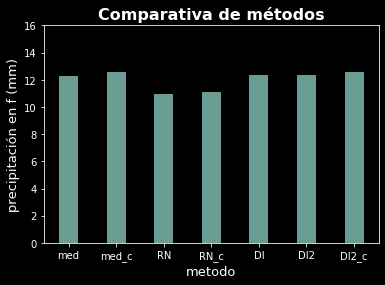

In [36]:
resultados = [po_mm, po_mmc, po_rn, po_rnc, po_di1, po_di2, po_di2c]

plt.bar(range(len(resultados)), resultados, width=0.4, alpha=.75)
plt.title('Comparativa de métodos', fontsize=16, weight='bold')
plt.xlabel('metodo', fontsize=13)
plt.xticks(range(len(resultados)), ['med', 'med_c', 'RN', 'RN_c', 'DI',
                                    'DI2', 'DI2_c'])
plt.ylim((0, 16))
plt.ylabel('precipitación en f (mm)', fontsize=13);

### Interpolación
Los métodos anteriormente mostrados se aplican también para la interpolación de mapas de precipitación. Seguidamente, generaremos un mapa de precipitación en la tormenta mediante el método de la distancia inversa.

El primer paso es crear una función de _Python_ que calcule la distancia inversa.

In [37]:
def IDW(x, y, estX, estY, estP, b=-2):
    """Interpolar mediante el método de la distancia inversa (inverse distance
    weighted)
    
    Entradas:
    ---------
    x:       float. Coordenada X del punto objetivo
    y:       float. Coordenada Y del punto objetivo
    estX:    Series. Serie de coordenadas X de las estaciones con dato
    estY:    Series. Serie de coordenadas Y de las estaciones con dato
    estP:    Series. Serie con el dato observado en las estaciones
    b:       int. Exponente de la distancia para calcular su inverso
    
    Salida:
    -------
    p:       float. Precipitación interpolada en el punto (x, y)
    """
    
    # distancia al punto de cálculo
    distX = x - estX                    # distancia en el eje X
    distY = y - estY                    # distancia en el eje X
    dist = np.sqrt(distX**2 + distY**2) # distancia total
    # inverso de la distancia
    idw = dist**b
    # interpolar
    p = np.sum(idw / np.sum(idw) * estP)
    
    return round(p, 1)

In [38]:
# Prueba de la función para repetir la interpolación en el punto F
IDW(data1.loc['F', 'X'], data1.loc['F', 'Y'], data1_['X'], data1_['Y'],
    data1_['p'], b=-2)

12.4

Ahora aplicaremos la función de interpolación iterativamente sobre las celdas del mapa que queremos interpolar. Para ello, hay que crear el mapa antes que nada.

In [39]:
# Coordenadas X e Y de un raster cuadrados
xo, xf = 382200, 390200
X = np.arange(xo, xf, 100)
yo, yf = 4771400, 4779400
Y = np.arange(yo, yf, 100)

In [40]:
# crear un mapa vacío (NaN) con las dimensiones de las coordenadas
pcp = np.zeros((len(X), len(Y)))

In [41]:
# interpolar la precipitación en cada una de las celdas del mapa
for i, y in enumerate(Y[::-1]): # importante invertir la posición de 'Y'
    for j, x in enumerate(X):
        pcp[i, j] = IDW(x, y, data1_.X, data1_.Y, data1_.p, b=-2)

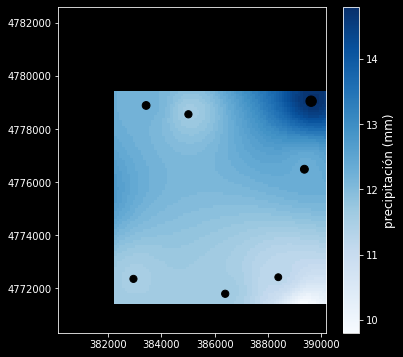

In [42]:
# gráfico con las estaciones y el mapa de precipitación interpolada
# -----------------------------------------------------------------
# configuración
plt.figure(figsize=(6, 6))
plt.axis('equal')

# mapa interpolado
pmap = plt.imshow(pcp, extent=[xo, xf, yo, yf], cmap='Blues')
cb = plt.colorbar(pmap)
cb.set_label('precipitación (mm)', rotation=90, fontsize=12)

# puntos con las estaciones
plt.scatter(data1_.X, data1_.Y, c='k', s=data1_.p**3/30);